In [28]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import statsmodels.api as sm

from skgrf.ensemble import GRFForestLocalLinearRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer

In [29]:
# Import a list of all signals, and whether they are a continuous or discrete signal
signal_doc = pd.read_csv("SignalDoc.csv")
is_continuous_signal = (signal_doc[signal_doc["Cat.Signal"] == "Predictor"].set_index("Acronym")["Cat.Form"] == "continuous").to_dict()

# Import joined dataset of signals and prices
df = pd.read_csv("signed_predictors_all_wide.csv")

In [30]:
def clean_data(df, use_signal_threshold=0.9):

    def full_index(start, end):
        '''
        Return a full list of all months between start and end in yyyymm string format.
        '''
        return [
            int(str(year) + str(month).rjust(2, "0"))
            for year in range(int(str(start)[:-2]), int(str(end)[:-2]) + 1)
            for month in range(1, 13)
        ]

    def compute_returns(df):
        '''
        Compute a new "ret" column with the one-period percentage returns for a particular stock.
        df must contain observations associated with one stock only.
        '''
        df = df.set_index("yyyymm").reindex(full_index(df["yyyymm"].min(), df["yyyymm"].max()))
        return df.assign(ret=np.exp(-df["Price"]).pct_change(fill_method=None).shift(-1)) \
            .dropna(subset="ret") \
            .reset_index()

    def clean_monthly_data(df):
        '''
        First, filter out "micro-stocks", defined as stocks occupying the bottom 2% of cumulative
        market cap of all stocks, sorted in descending order of market cap. Then, apply clean_signal_data
        to each individual signal.
        '''
        df = df.sort_values(by="Size")
        df = df.assign(cumsize=np.exp(-df["Size"]).cumsum())
        return df[df["cumsize"] < .98 * np.exp(-df["Size"]).sum()] \
            .drop(labels="cumsize", axis=1) \
            .apply(clean_signal_data)

    def clean_signal_data(series):
        '''
        If this signal's data series is at least 90% complete (contains fewer than 10% NANs), impute the
        remaining NANs. Otherwise, do nothing, since this feature will be discarded during backtesting if
        even a single NAN is present.
        '''
        if series.name in is_continuous_signal and series.isna().sum() < 0.1 * series.shape[0]:
            simple_imputer = SimpleImputer(strategy="mean" if is_continuous_signal[series.name] else "most_frequent")
            return pd.Series(simple_imputer.fit_transform(series.values.reshape([-1, 1])).reshape([-1]), index=series.index)
        else:
            return series

    # Exclude non-common shares
    df = df[df["shrcd"].isin([10, 11])]

    # Exclude financial shares
    df = df[~df["siccd"].between(6000, 6999)]

    # Perform some basic cleaning and apply the functions defined above
    return df.replace([np.inf, -np.inf], np.nan) \
        .dropna(subset=["Price", "shrcd"]) \
        .groupby("permno").apply(compute_returns) \
        .reset_index(drop=True) \
        .groupby("yyyymm").apply(clean_monthly_data) \
        .reset_index(drop=True) \
        .drop(labels=["shrcd", "siccd"], axis=1)

In [31]:
def backtest(models, data, train_window=10, val_window=5, test_window=2, start_year=1970, end_year=2022, use_cache=True):

    def simulate_returns(df, scorer):
        '''
        Use the model scorer to assign a "score" column to the validation or test data, and then compute
        the performance of the model on each month individually using compute_return.
        '''
        return df.groupby("yyyymm", as_index=False) \
            .apply(lambda monthly_df: compute_return(monthly_df.assign(score=scorer(monthly_df.drop(columns=["permno", "yyyymm", "ret"]))))) \
            .set_index("yyyymm") \
            .values
    
    def compute_return(scored_data):
        '''
        Sort the data by the model score and compute the average return of the top decile minus the average
        return of the bottom decile.
        '''
        sorted_data = scored_data.sort_values(by="score")
        decile_count = int(sorted_data.shape[0]/10)
        return (sorted_data["ret"][-decile_count:].mean() - sorted_data["ret"][:decile_count].mean()) / 2
        
    model_values = dict()
    for model_index, model in enumerate(models):

        # Load results from cache if applicable
        if use_cache and os.path.exists(f"backtest_results/{model.name()}.npy"):
            model_values[model.name()] = np.load(f"backtest_results/{model.name()}.npy")
            continue

        current_year = start_year
        portfolio_value = [1]

        # Loop through all years in the specified range with a rolling window
        while current_year < end_year - train_window - val_window:

            train_end_year = current_year + train_window
            val_end_year = train_end_year + val_window
            test_end_year = val_end_year + test_window

            full_window_data = data[data["yyyymm"].between(100 * current_year, 100 * test_end_year)] \
                .dropna(axis=1)
            data_train = full_window_data[full_window_data["yyyymm"] < 100 * train_end_year]
            data_val = full_window_data[full_window_data["yyyymm"].between(100 * train_end_year, 100 * val_end_year)]
            data_train_val = full_window_data[full_window_data["yyyymm"] < 100 * val_end_year]
            data_test = full_window_data[full_window_data["yyyymm"].between(100 * val_end_year, 100 * min(end_year, test_end_year))]

            if model.is_dynamic():
                # Dynamic model trains on 10 years and validates on 5 years. The model training must
                # accept a "validator" parameter, which is a function that will validate the trained
                # model on a validation set.
                model.train(
                    data_train.drop(columns=["permno", "yyyymm", "ret"]),
                    data_train["ret"],
                    lambda scorer: (simulate_returns(data_val, scorer) + 1).prod(),
                )
            else:
                # Static model trains on 15 years and does not validate
                model.train(
                    data_train_val.drop(columns=["permno", "yyyymm", "ret"]),
                    data_train_val["ret"],
                    None
                )

            # Simulate the model performance on 2 years, and append the simulated portfolio balances to the running list
            portfolio_value += list((simulate_returns(data_test, model.score) + 1).cumprod() * portfolio_value[-1])
            current_year += test_window

        model_values[model.name()] = portfolio_value

        # Save results to cache if applicable
        if use_cache:
            np.save(f"backtest_results/{model.name()}.npy", portfolio_value)

    return model_values

In [32]:
class SizeModel:
    '''
    Dummy model that just chooses the smallest stocks.
    '''

    def train(self, X, y, validator):
        pass

    def score(self, X):
        return X["Size"]

    def name(self):
        return "Size Model"

    def is_dynamic(self):
        return False

In [33]:
class OlsModel:
    '''
    Static unregularized OLS model that trains on all features.
    '''

    def train(self, X, y, validator):
        model = sm.OLS(y, sm.add_constant(X))
        self.ols = model.fit()

    def score(self, X):
        return self.ols.predict(sm.add_constant(X))

    def name(self):
        return "OLS Model"

    def is_dynamic(self):
        return False

In [34]:
class VanillaRFModel:
    '''
    Vanilla Random Forest model that trains on all features. It can be made static by supplying only
    one choice for each hyperparameter, or dynamic by supplying multiple choices in at least one hyperparameter.
    '''

    def __init__(self, n_estimators_set=[100], max_depth_set=[10], max_features_set=[1.0]):
        self.n_estimators_set = n_estimators_set
        self.max_depth_set = max_depth_set
        self.max_features_set = max_features_set

    def _fit(self, X, y, n_estimators, max_depth, max_features):
        self.rf = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=0
        )
        self.rf.fit(X, y)

    def train(self, X, y, validator):
        '''
        If this is a static model, simply fit the Random Forest model using the supplied hyperparameters.
        Otherwise, loop through the grid of hyperparameters to select which selection performs best
        against the validation set.
        '''
        if not self.is_dynamic():
            self._fit(X, y, self.n_estimators_set[0], self.max_depth_set[0], self.max_features_set[0])
            return

        best_returns = -1
        for n_estimators in self.n_estimators_set:
            for max_depth in self.max_depth_set:
                for max_features in self.max_features_set:
                    self._fit(X, y, n_estimators, max_depth, max_features)
                    returns = validator(self.score)
                    if returns > best_returns:
                        best_model = self.rf
                        best_returns = returns
        self.rf = best_model

    def score(self, X):
        return self.rf.predict(X)

    def name(self):
        return f"Vanilla RF Model ({self.n_estimators_set} estimators, {self.max_depth_set} depth, {self.max_features_set} max features"

    def is_dynamic(self):
        return len(self.n_estimators_set) > 1 or len(self.max_depth_set) > 1 or len(self.max_features_set) > 1

In [35]:
class ExtraTreesModel(VanillaRFModel):
    '''
    Swap out the Vanilla Random Forest model with an Extremely Randomized Trees model.
    '''

    def _fit(self, X, y, n_estimators, max_depth, max_features):
        self.rf = ExtraTreesRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            random_state=0
        )
        self.rf.fit(X, y)

    def name(self):
        return f"Extra Trees Model ({self.n_estimators_set} estimators, {self.max_depth_set} depth, {self.max_features_set} max features"

In [36]:
class LocalLinearForestModel(VanillaRFModel):
    '''
    Swap out the Vanilla Random Forest model with a Local Linear Forest model.
    '''

    def _fit(self, X, y, n_estimators, max_depth, max_features):
        self.rf = GRFForestLocalLinearRegressor(
            n_estimators=n_estimators,
            min_node_size=int(X.shape[0]/2**max_depth),
            seed=0
        )
        self.rf.fit(X, y)

    def score(self, X):
        return self.rf.predict(X)

    def name(self):
        return f"Local Linear Forest Model ({self.n_estimators_set} estimators, {self.max_depth_set} depth, {self.max_features_set} max features"

In [10]:
cleaned_data = clean_data(df)

In [24]:
models = [
    OlsModel(),
    # VanillaRFModel(max_features_set=[1.0, .33, "sqrt"]),
    # LocalLinearForestModel(max_depth_set=[3]),
    # LocalLinearForestModel(),
    # LocalLinearForestModel(max_depth_set=[25]),
    # LocalLinearForestModel(max_depth_set=[3, 10, 25]),
    # ExtraTreesModel(max_depth_set=[3]),
    # ExtraTreesModel(),
    # ExtraTreesModel(max_depth_set=[25]),
    # ExtraTreesModel(max_depth_set=[3, 10, 25]),
    # ExtraTreesModel(max_features_set=[.33]),
    # ExtraTreesModel(max_features_set=["sqrt"]),
    # ExtraTreesModel(max_features_set=[1.0, .33, "sqrt"]),
    # ExtraTreesModel(max_depth_set=[3, 10, 25], max_features_set=[1.0, .33, "sqrt"]),
]
model_values = backtest(models, cleaned_data, val_window=0, test_window=1, use_cache=False)

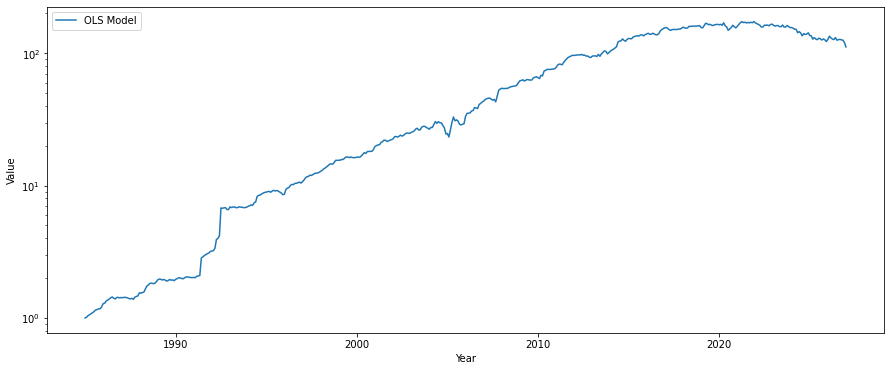

In [25]:
plt.figure(figsize=(15,6))
for model_name in model_values:
    plt.plot([1985 + i/12 for i in range(len(model_values[model_name]))], model_values[model_name], label=model_name)
plt.xlabel("Year")
plt.ylabel("Value")
plt.yscale("log")
plt.legend()
plt.show()